## TensorFlow 基础用法

### 1. Setup and basic usage

In [3]:
import tensorflow as tf
import os
import cProfile

In Tensorflow 2.0, eager execution is enabled by default.

In [4]:
tf.executing_eagerly()

True

Now you can run TensorFlow operations and the results will return immediately:

In [5]:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

hello, [[4.]]


Enabling eager execution changes how TensorFlow operations behave—now they immediately evaluate and return their values to Python. tf.Tensor objects reference concrete values instead of symbolic handles to nodes in a computational graph. Since there isn't a computational graph to build and run later in a session, it's easy to inspect results using print() or a debugger. Evaluating, printing, and checking tensor values does not break the flow for computing gradients.

Eager execution works nicely with NumPy. NumPy operations accept tf.Tensor arguments. The TensorFlow tf.math operations convert Python objects and NumPy arrays to tf.Tensor objects. The tf.Tensor.numpy method returns the object's value as a NumPy ndarray.

In [7]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [11]:
# Broadcasting support
b = tf.add(a, 1)
# b = a+1
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [12]:
# Operator overloading is supported
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [13]:
# Use NumPy values
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [14]:
# Obtain numpy value from a tensor:
print(a.numpy())
# => [[1 2]
#     [3 4]]

[[1 2]
 [3 4]]


### 2. Dynamic control flow

A major benefit of eager execution is that all the functionality of the host language is available while your model is executing. So, for example, it is easy to write [fizzbuzz](https://en.wikipedia.org/wiki/Fizz_buzz):

In [15]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

In [16]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


This has conditionals that depend on tensor values and it prints these values at runtime.

### 3. Eager training

#### 3.1 Computing gradients

In [25]:
w = tf.Variable([[1.0,2.0]])
with tf.GradientTape() as tape:
  loss = w ** 3

grad = tape.gradient(loss, w)
print(grad)  # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32)

tf.Tensor([[ 3. 12.]], shape=(1, 2), dtype=float32)


#### 3.2 Train a model

In [26]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

11493376/11490434 [==============================] - 6s 1us/step


In [27]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [28]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[-0.01262113 -0.03256937 -0.02730978 -0.0201042  -0.01662768  0.0076818
  -0.00419451  0.00244716  0.01966749 -0.01200661]]


In [29]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [30]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)
    
    # Add asserts to check the shape of the output.
    tf.debugging.assert_equal(logits.shape, (32, 10))
    
    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [31]:
def train(epochs):
  for epoch in range(epochs):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('Epoch {} finished'.format(epoch))

In [32]:
train(epochs = 3)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished


Text(0, 0.5, 'Loss [entropy]')

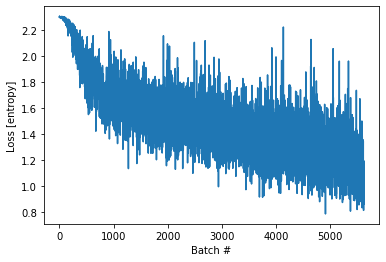

In [33]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

#### 3.3 Variables and optimizers

#### 3.4 Object-based saving

#### 3.5 Object-oriented metrics

#### 3.6 Summaries and TensorBoard

### 4. Advanced automatic differentiation topics